This notebook is the first step in Kealie Pretzlav's Springboard Capstone 2 project. 
This notebook downloads the appropriate datasets, merges them, and checks for missing values and duplicates. 
Further data processing will occur in future steps. 

In [34]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv
import requests

In [35]:
### download storm data
storm_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
file_list = list(pd.read_html(storm_url, skiprows=2)[0]['Parent Directory'].dropna())
years_to_dl = range(1996, 2022, 1) ##download data for 1996 on, no flood data prior
filename_to_dl = [f for f in file_list if 'details-ftp_v1.0_d' in f]

##initialize data subset rather than downloading whole storm event dataset
df_flood = pd.DataFrame()
flood_types = ['Flood', 'Flash Flood']

for year in years_to_dl:
    filename = [s for s in file_list if 'details-ftp_v1.0_d' + str(year) in s][0]
    df_flood_year = pd.read_csv(storm_url + filename, dtype='object')
    df_flood = pd.concat([df_flood, df_flood_year[df_flood_year['EVENT_TYPE'].isin(flood_types)]])
    print(year)

df_flood.head()

1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
1,199610,21,900,199610,21,900,2052748,5570362,OKLAHOMA,40,...,NaN,NaN,DURANT,NaN,NaN,NaN,NaN,Flash flood waters washed out a small bridge a...,NaN,PDC
25,199601,24,1200,199601,24,1200,1000569,5536059,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"On the 23rd, many areas received around an inc...",NaN,PDC
34,199601,22,700,199601,31,1159,1002242,5549485,KENTUCKY,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowmelt and heavy rain caused widespread floo...,NaN,PDC
44,199601,26,2330,199601,27,630,2404288,5537263,NORTH CAROLINA,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prolonged rain became heavier following the ic...,NaN,PDC
69,199601,19,830,199601,20,700,2057213,5583210,NEW YORK,36,...,NaN,NaN,COUNTYWIDE,NaN,NaN,NaN,NaN,NaN,NaN,PDC


In [36]:
df_flood.head().T

,1,25,34,44,69
BEGIN_YEARMONTH,199610,199601,199601,199601,199601
BEGIN_DAY,21,24,22,26,19
BEGIN_TIME,900,1200,700,2330,830
END_YEARMONTH,199610,199601,199601,199601,199601
END_DAY,21,24,31,27,20
END_TIME,900,1200,1159,630,700
EPISODE_ID,2052748,1000569,1002242,2404288,2057213
EVENT_ID,5570362,5536059,5549485,5537263,5583210
STATE,OKLAHOMA,INDIANA,KENTUCKY,NORTH CAROLINA,NEW YORK
STATE_FIPS,40,18,21,37,36


In [37]:
## take a look at flood types to see why all zip code has a flood

df_flood.describe().T
df_flood['FLOOD_CAUSE'].value_counts()

FLOOD_CAUSE
Heavy Rain                      88730
Heavy Rain / Snow Melt           4917
Heavy Rain / Tropical System     2431
Heavy Rain / Burn Area            738
Ice Jam                           698
Dam / Levee Break                 231
Planned Dam Release               175
Name: count, dtype: int64

In [38]:
##change col names to lowercase
df_flood.columns = df_flood.columns.str.lower()
df_flood.columns


Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_36326/2766726960.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')


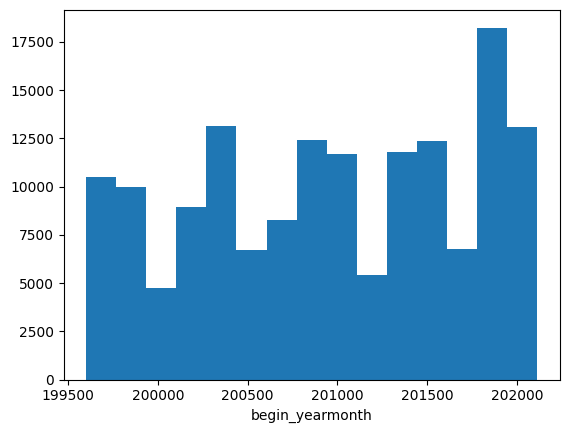

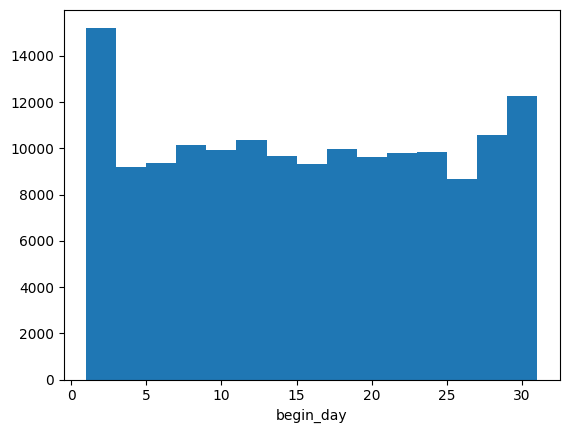

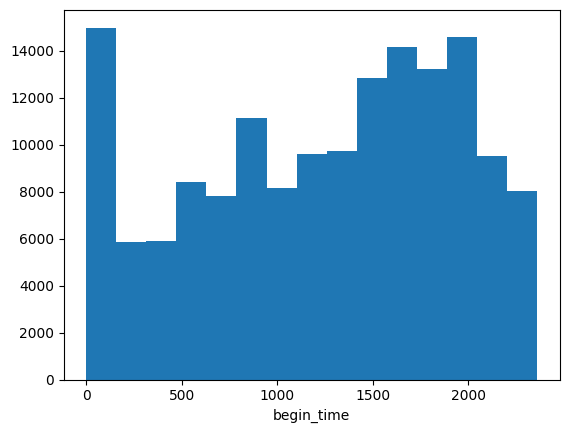

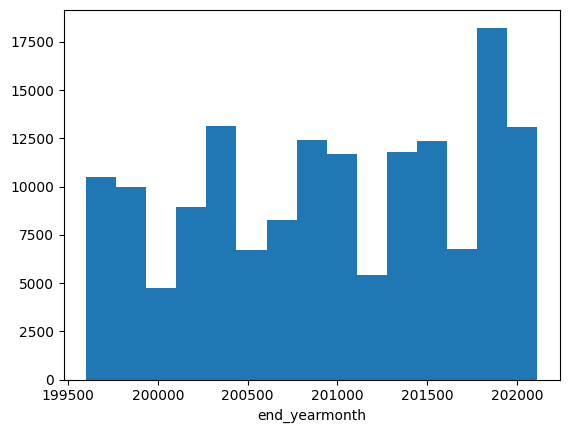

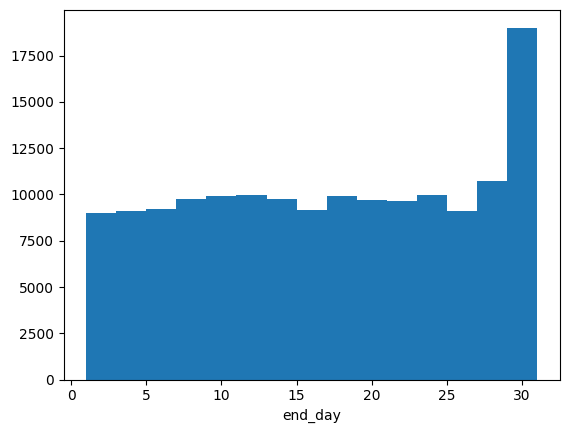

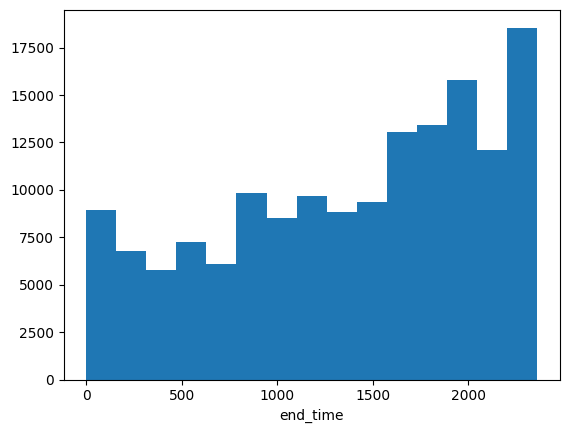

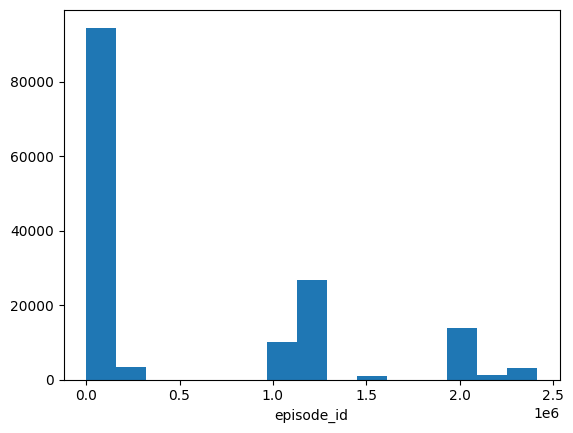

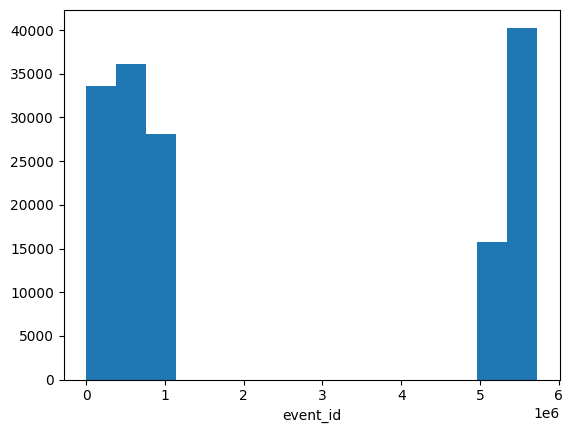

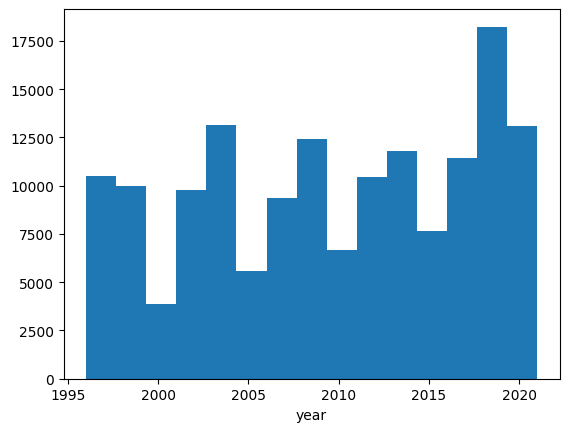

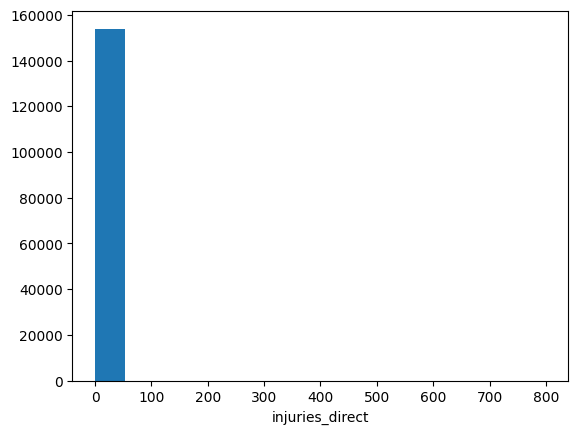

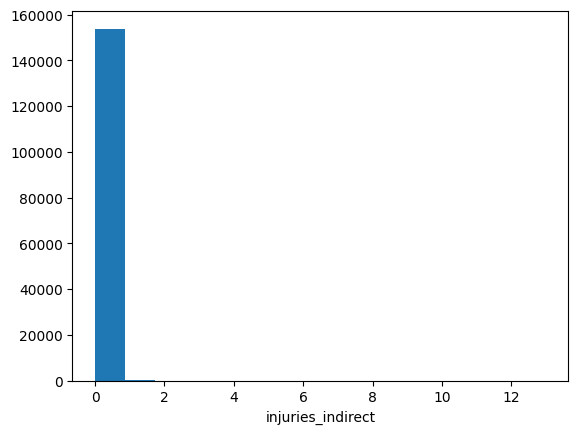

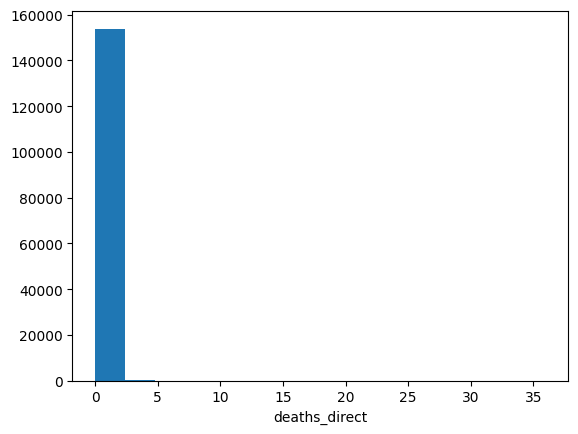

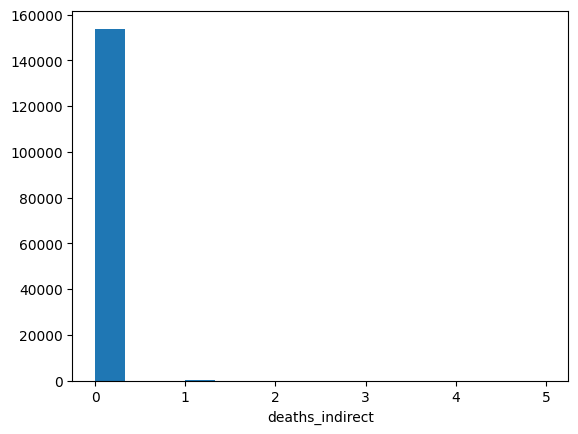

In [39]:
##check for outliers
flood_numeric_names = ['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
                       'end_day', 'end_time', 'episode_id', 'event_id','year',
                       'injuries_direct', 'injuries_indirect', 'deaths_direct','deaths_indirect']
df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')
### check numeric outliers
for n in df_flood[flood_numeric_names].columns:
    plt.hist(df_flood[flood_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()



_Things to notice about histograms/outliers_
- Time start and day start suggests a slight bias toward the start/end day and first/end time, suggesting unknown data uses these as defaults
- outlier on injuries_direct, injuries_indirect, deaths_direct, deaths_indirect. Unsure if that is real or unknown data. 


In [40]:
##check for missing values in key columns
print(len(df_flood))
df_flood.isna().sum()

153990


begin_yearmonth            0
begin_day                  0
begin_time                 0
end_yearmonth              0
end_day                    0
end_time                   0
episode_id                 0
event_id                   0
state                      0
state_fips                 0
year                       0
month_name                 0
event_type                 0
cz_type                    0
cz_fips                    0
cz_name                    0
wfo                        0
begin_date_time            0
cz_timezone                0
end_date_time              0
injuries_direct            0
injuries_indirect          0
deaths_direct              0
deaths_indirect            0
damage_property        35527
damage_crops           49988
source                 13380
magnitude             153892
magnitude_type        153989
flood_cause            56070
category              153990
tor_f_scale           153990
tor_length            153990
tor_width             153990
tor_other_wfo 

Lots of columns have mostly missing data. Drop columns with more than 100k missing values (tor_ columns are for tornado events). Also drop columns that aren't needed. 

In [41]:
### done need all the data, drop some now to clean up
df_flood = df_flood.dropna(thresh=100000, axis=1)
df_flood_drop = df_flood.drop(['begin_range', 'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth', 'end_location'], axis=1)
##
df_flood_drop.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'begin_lat', 'begin_lon', 'end_lat', 'end_lon', 'episode_narrative',
       'event_narrative', 'data_source'],
      dtype='object')

Lat/Long has lots of missing values. How many have both missing? 

In [42]:
print('lat counts: ', df_flood_drop[['begin_lat', 'end_lat']].isna().sum(1).value_counts())
print('lon counts: ', df_flood_drop[['begin_lon', 'end_lon']].isna().sum(1).value_counts())
print('all lat/long counts: ', df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1).value_counts())

lat counts:  0    103535
2     50455
Name: count, dtype: int64
lon counts:  0    103535
2     50455
Name: count, dtype: int64
all lat/long counts:  0    103535
4     50455
Name: count, dtype: int64


50k are missing all lat/long info. Isolated to older data? Specific state?

<Axes: >

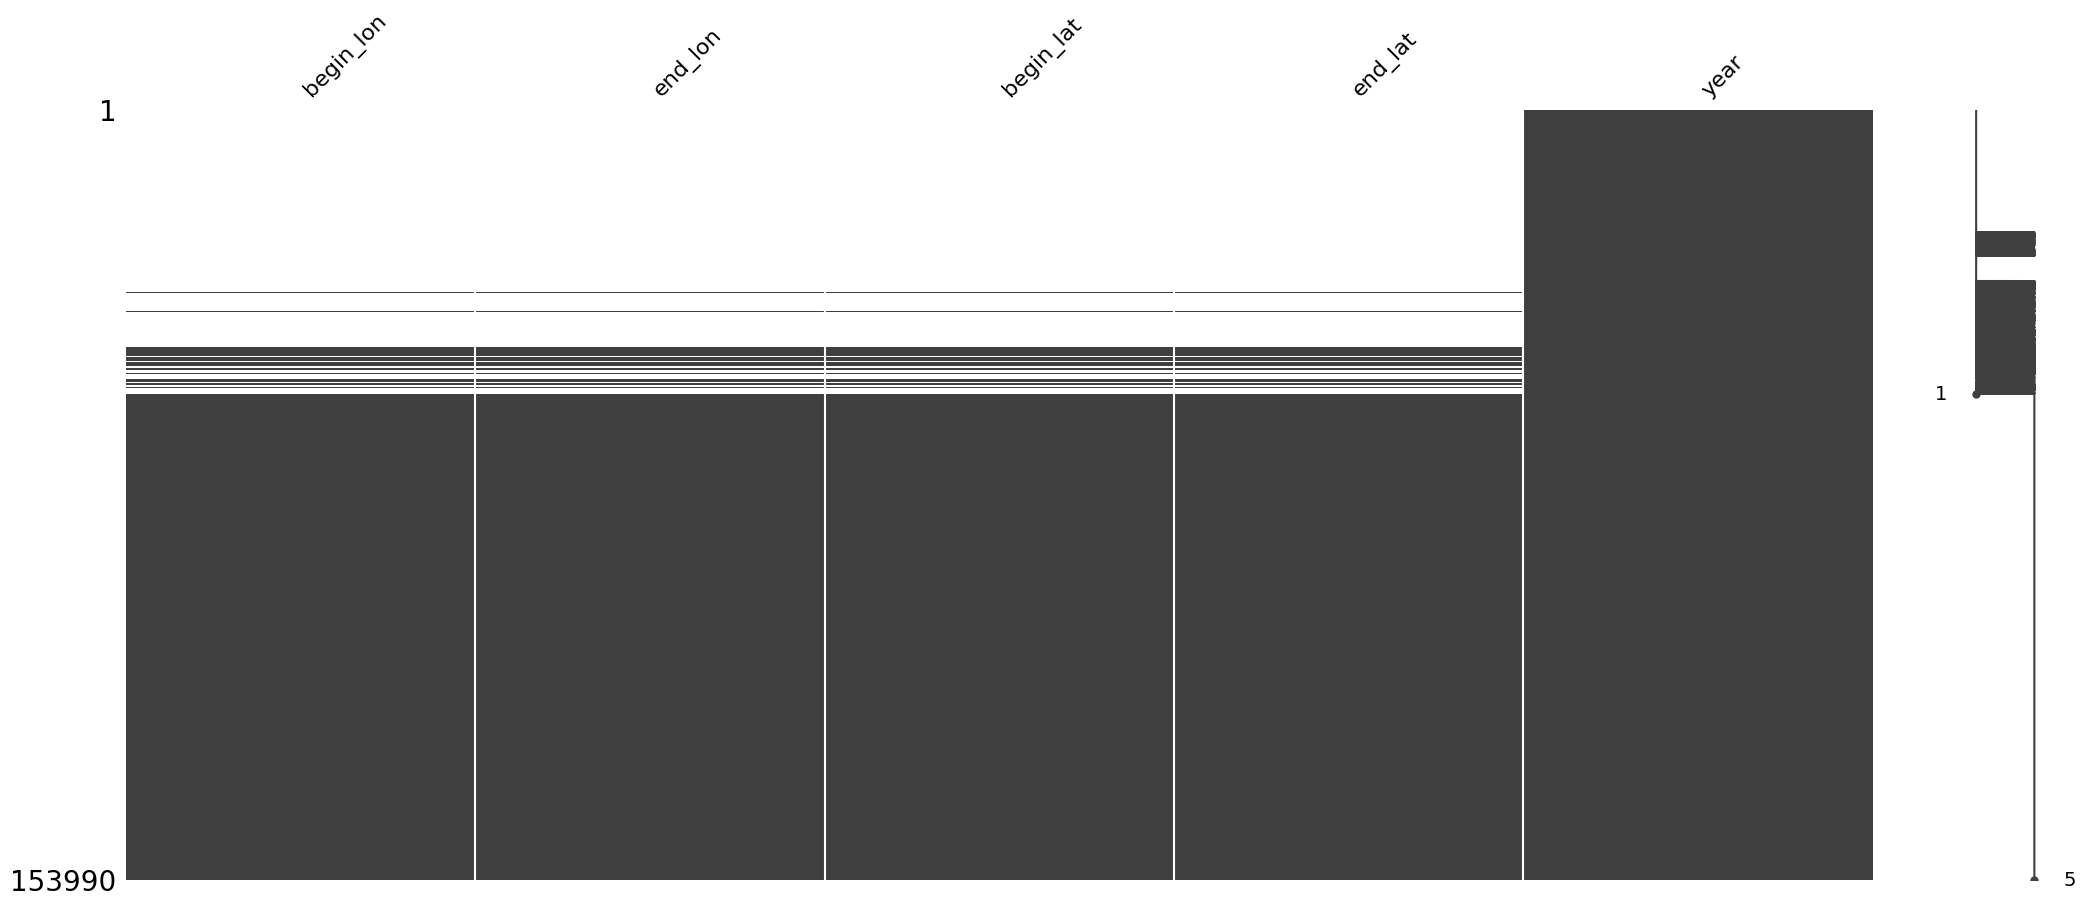

In [43]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'year']].sort_values('year'))

<Axes: >

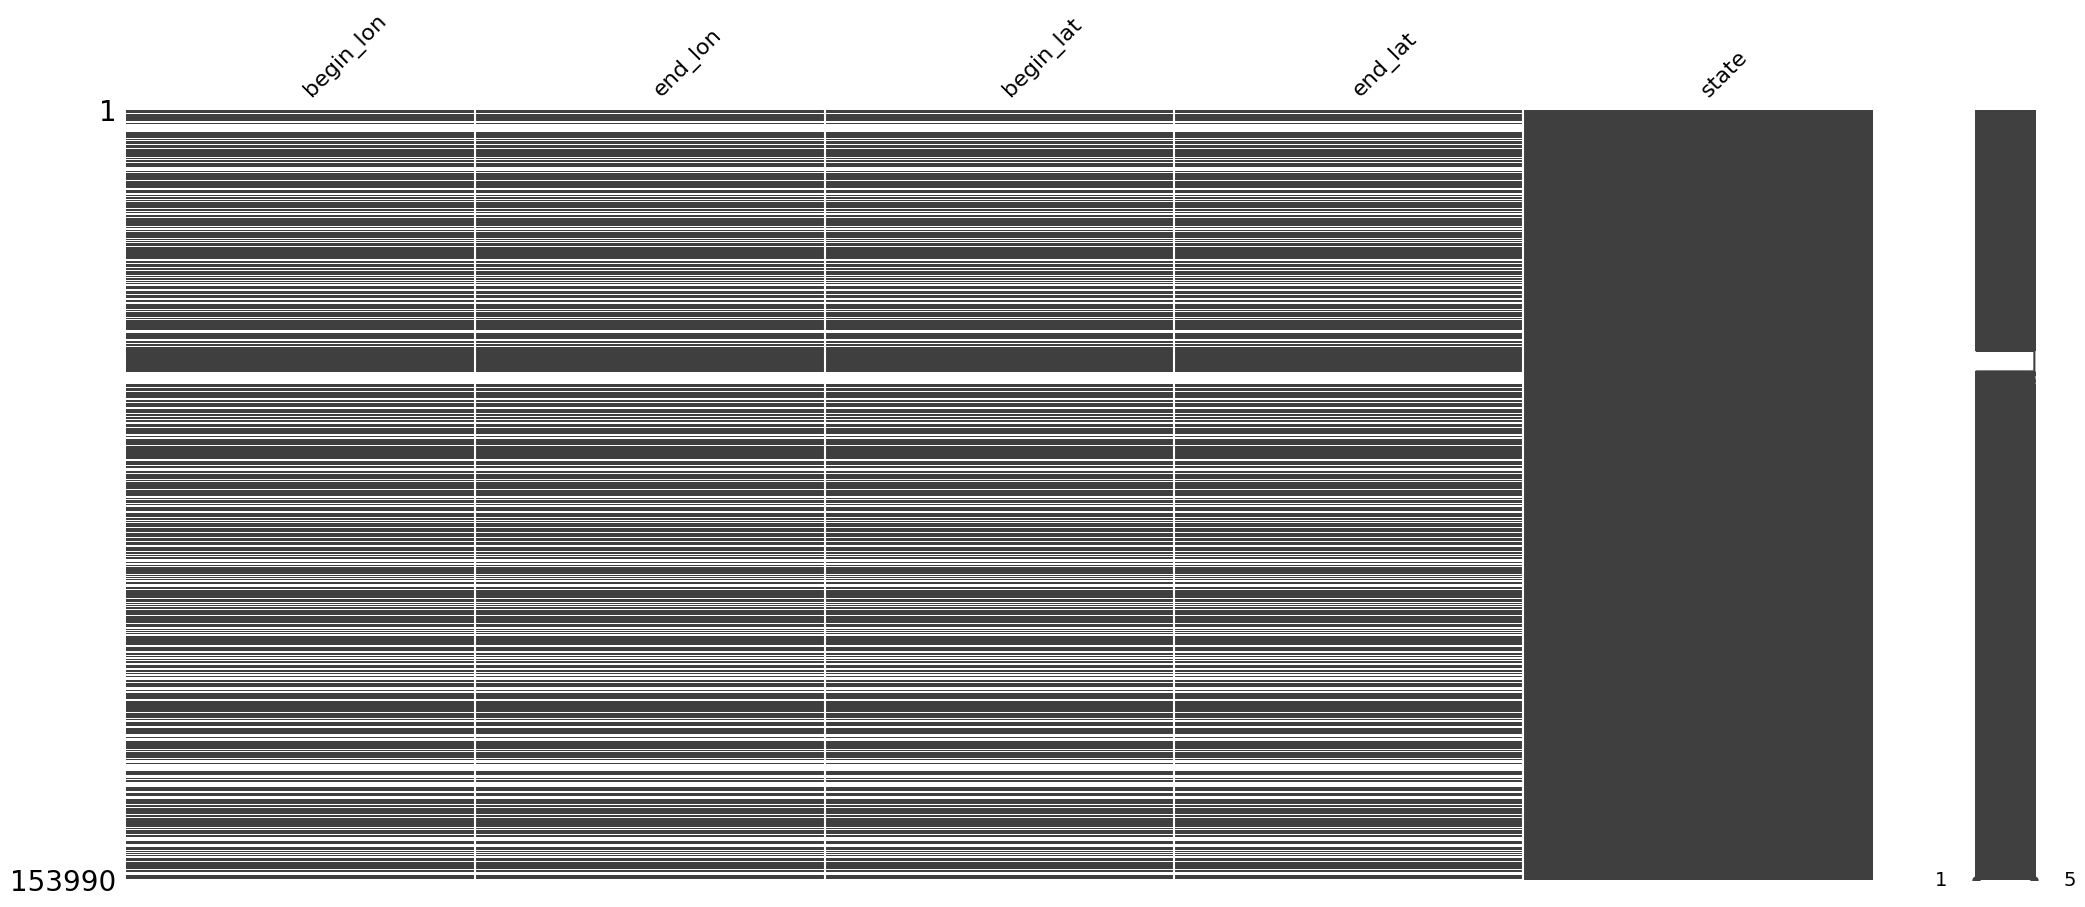

In [44]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'state']].sort_values('state'))

In [45]:
df_missingloc = df_flood_drop.loc[df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1) == 4, :]
df_missingloc['year'].value_counts().sort_index()  / df_flood_drop.groupby('year').count()['event_id'] * 100

year
1996    100.000000
1997    100.000000
1998    100.000000
1999    100.000000
2000    100.000000
2001     96.596367
2002    100.000000
2003     95.012107
2004     96.599914
2005     24.605452
2006     63.469493
2007           NaN
2008           NaN
2009           NaN
2010           NaN
2011           NaN
2012           NaN
2013           NaN
2014           NaN
2015           NaN
2016           NaN
2017           NaN
2018           NaN
2019           NaN
2020           NaN
2021           NaN
dtype: float64

Looks like most missing data is in early years. We'll drop missing for now, but note the percentage of missing lat/long for 2001 - 2006 may make those years less helpful. Nan in 2007 on becuase no missing values. 

In [46]:
# df_flood_drop = 
df_flood_drop2 = df_flood_drop.dropna(subset=['begin_lon', 'end_lon', 'begin_lat', 'end_lat'])
print('number floods before dropping missing locs:', len(df_flood_drop), 'number floods after dropping:', len(df_flood_drop2))

number floods before dropping missing locs: 153990 number floods after dropping: 103535


In [47]:
#import 2020 census zip code tabulation areas
zcta = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip')

zcta.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.65390, -88.24713 33.654..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.34960, -86.81649 34.349..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."


In [48]:
#### merge zcta data to flood dataset
df_loc = pd.DataFrame([Point(str(x),str(y)) for x, y in zip(df_flood['begin_lon'], df_flood['begin_lat'])], columns=['locstr'])
df_loc.index = df_flood_drop['event_id']

gdf_flood = gpd.GeoDataFrame(df_loc, geometry='locstr', crs='EPSG:4269')
gdf_zcta = gpd.sjoin(gdf_flood, zcta, how='left')


Confirmed visual on maps that events with missing zip code were outside the census mapped ZCTA areas and so were removed. 

In [49]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')


In [50]:
##merge zip code back to flood data, remove events with missing zip code

df_flood_zip = df_flood_drop.merge(gdf_zcta[['ZCTA5CE20']], how='inner', left_on='event_id', right_index=True)
df_flood_zip = df_flood_zip.dropna(subset='ZCTA5CE20')
df_flood_zip.head()

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,damage_crops,source,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source,ZCTA5CE20
1426,200111,26,2100,200111,26,2300,1125447,5276096,TENNESSEE,47,...,NaN,LAW ENFORCEMENT,35.61667,-88.83333,35.61667,-88.83333,NaN,Several buildings had water in their basements...,PDS,38301
7965,200104,4,1800,200104,4,2300,1113012,5240447,MISSISSIPPI,28,...,NaN,EMERGENCY MANAGER,32.75,-89.25,32.75,-89.25,NaN,A significant flash flood event occurred due t...,PDS,39350
8121,200103,2,1530,200103,2,1730,1112592,5238548,MISSISSIPPI,28,...,NaN,AMATEUR RADIO,31.41667,-89.83333,31.41667,-89.83333,NaN,Localized flooding of roads occurred in wester...,PDS,39427
8122,200103,2,1530,200103,2,1800,1112592,5238549,MISSISSIPPI,28,...,NaN,AMATEUR RADIO,31.45,-89.75,31.45,-89.75,NaN,Localized flooding occurred on the streets in ...,PDS,39421
8124,200103,3,400,200103,3,600,1112592,5238551,MISSISSIPPI,28,...,NaN,EMERGENCY MANAGER,31.41667,-89.55,31.38333,-89.55,NaN,A few roads in the county had flooding.,PDS,39482


In [51]:
##define census data variables to pull, and the data label

fields_dict = {'NAME': 'Name',
               'B19081_001E': 'houseinc_1',
               'B19081_002E': 'houseinc_2',
               'B19081_003E': 'houseinc_3',
               'B19081_004E': 'houseinc_4',
               'B19081_005E': 'houseinc_5',
               'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1'
              }

fields = ','.join(list(fields_dict.keys()))
names = list(fields_dict.values()) + ['zcta']


In [52]:
### request data from api, put into dataframe

url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=zip%20code%20tabulation%20area:*&key=' + API_KEY

r_test = requests.get(url)
r_test.json()
df_census = pd.DataFrame(r_test.json()[1::], columns=names)

df_census.head()

,Name,houseinc_1,houseinc_2,houseinc_3,houseinc_4,houseinc_5,houseinc_top5,med_houseinc_12mon,household_public_assistance1,zcta
0,ZCTA5 00601,3852,10764,17479,26997,56362,96549,17526,5341,00601
1,ZCTA5 00602,4160,12496,20599,33220,73001,118717,20260,12777,00602
2,ZCTA5 00603,1427,9622,18169,34313,88526,154617,17703,19624,00603
3,ZCTA5 00606,2967,10850,19373,30163,55892,78806,19603,1948,00606
4,ZCTA5 00610,5104,13917,23066,35958,78734,129039,22796,8781,00610


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_36326/1852926619.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')


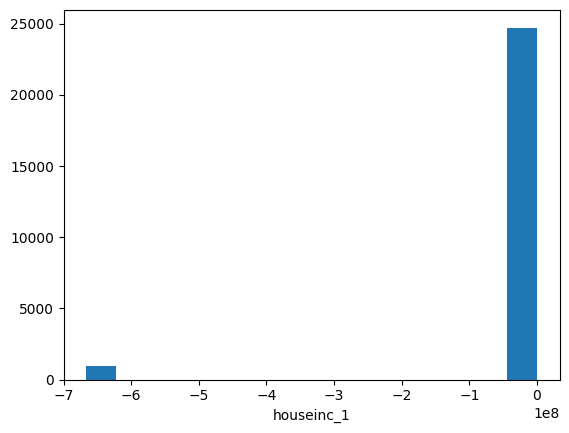

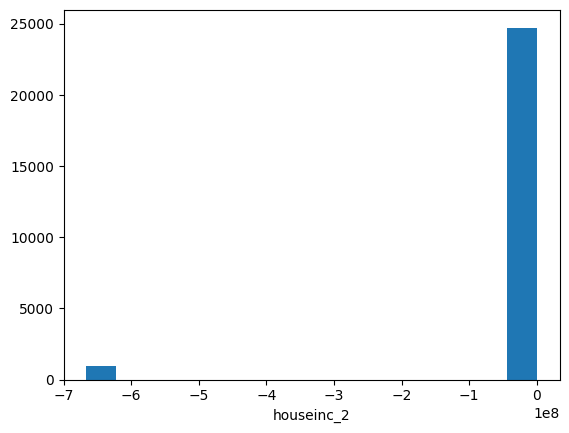

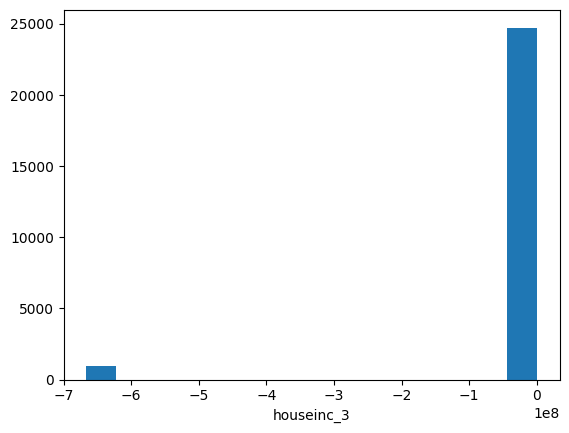

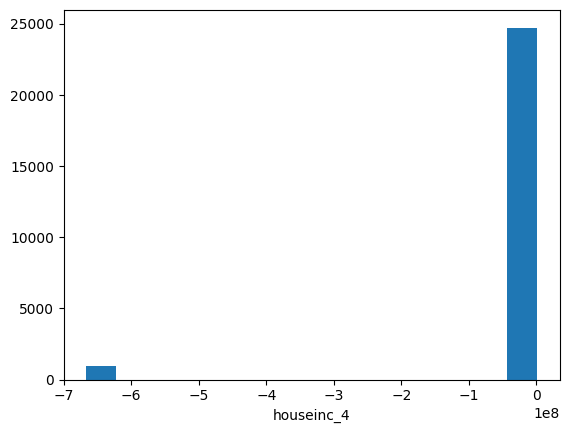

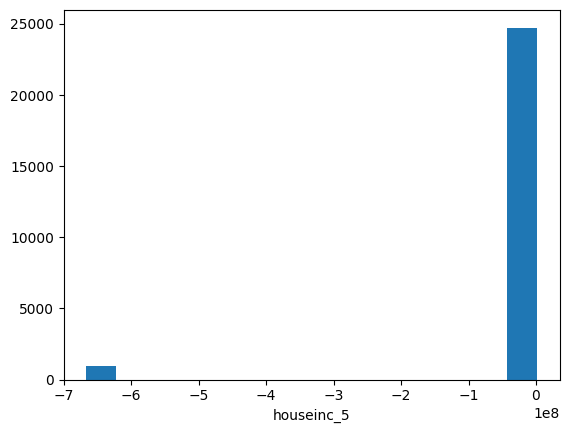

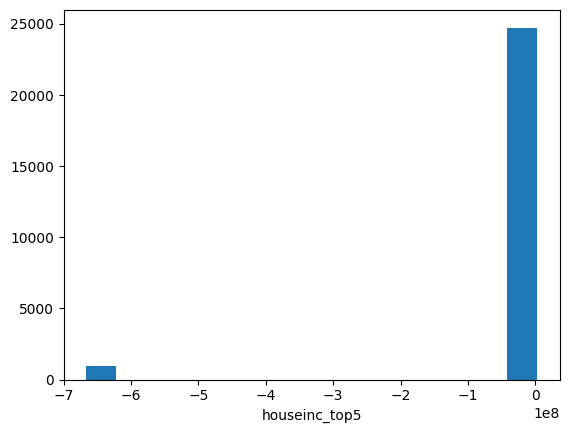

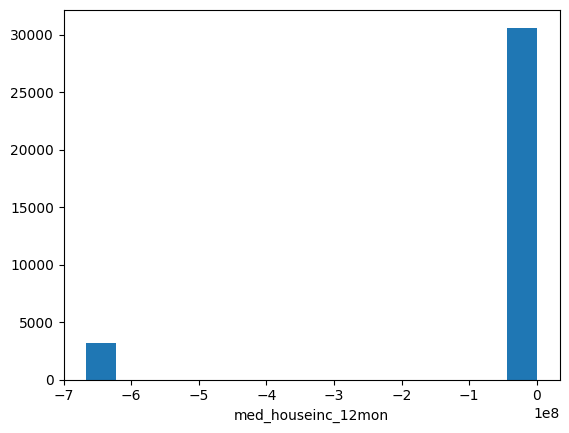

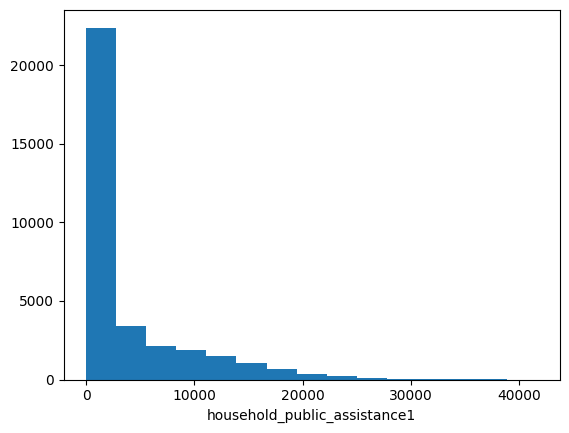

In [53]:
## check outliers

##check for outliers
df_census = df_census.replace(-666666666, np.nan)
census_numeric_names = ['houseinc_1', 'houseinc_2', 'houseinc_3', 'houseinc_4', 'houseinc_5', 'houseinc_top5', 
                        'med_houseinc_12mon', 'household_public_assistance1']

df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')

### check numeric outliers
for n in df_census[census_numeric_names].columns:
    plt.hist(df_census[census_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()

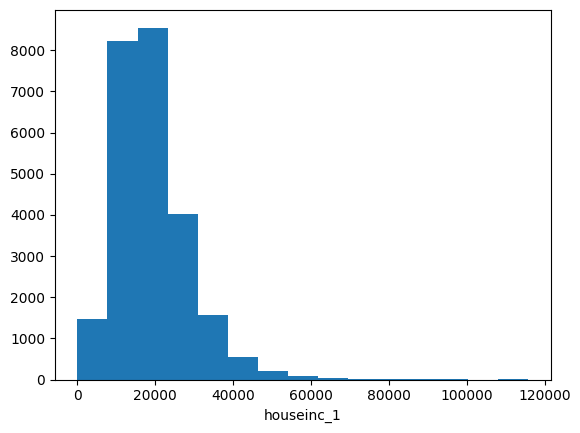

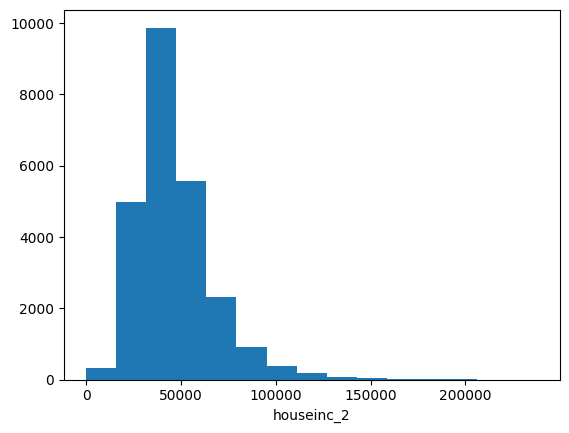

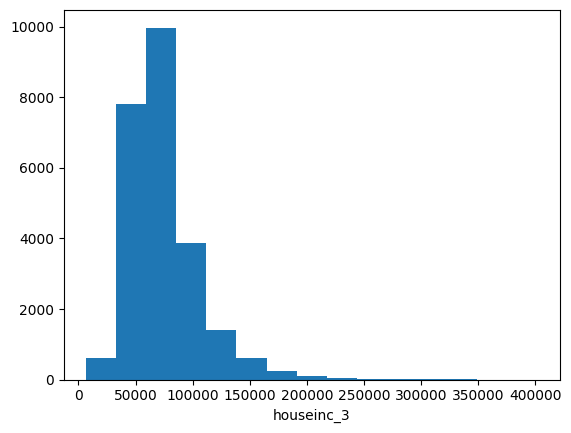

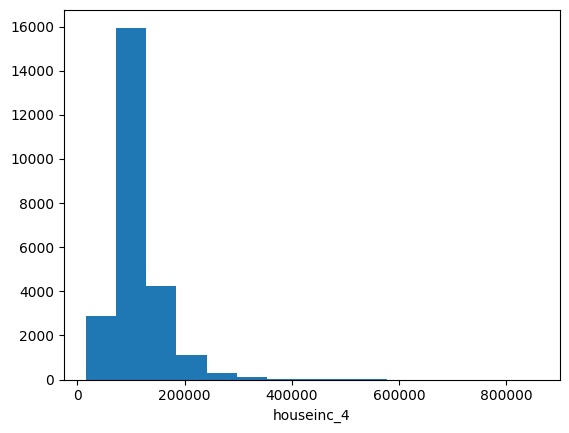

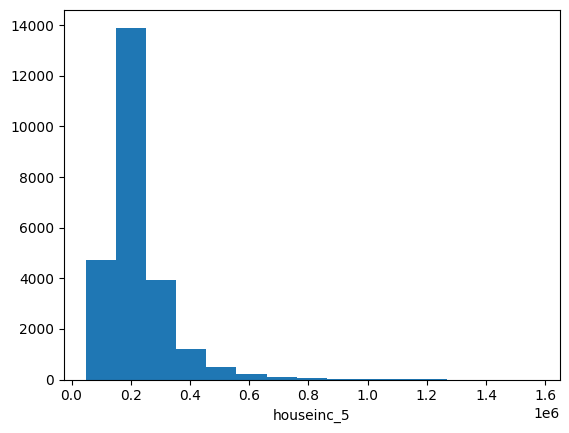

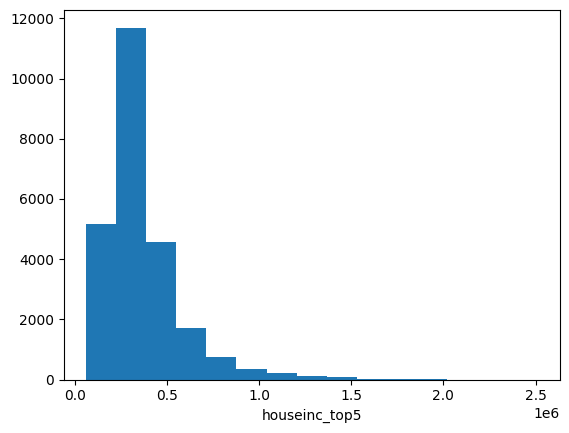

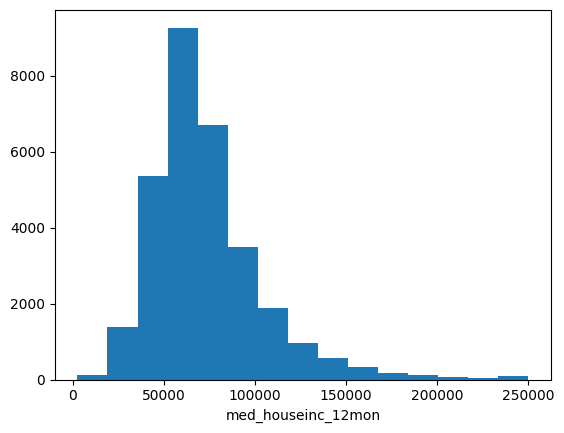

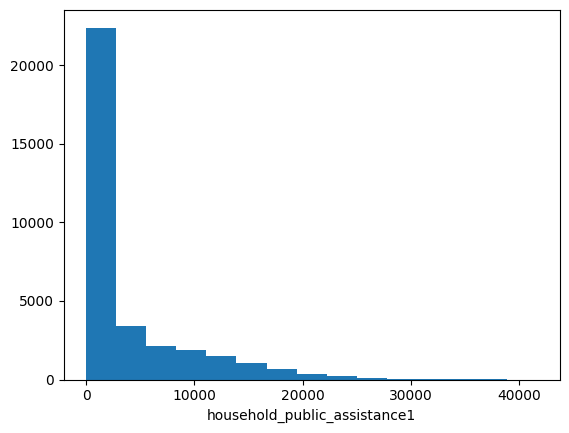

In [54]:
#looks like -666666666 is null value; replace
df_census = df_census.replace(-666666666, np.nan)


### check numeric outliers
for n in df_census[census_numeric_names].columns:
    plt.hist(df_census[census_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()

In [55]:
### merge census geography info w flood and zcta flood data
## only keep census zctas that have flood data

df_cen_fl = df_census.merge(df_flood_zip, how='right', left_on='zcta', right_on='ZCTA5CE20')
df_cen_fl.head().T

,0,1,2,3,4
Name,ZCTA5 38301,ZCTA5 39350,ZCTA5 39427,ZCTA5 39421,ZCTA5 39482
houseinc_1,7529.0,10534.0,NaN,11984.0,20482.0
houseinc_2,21138.0,26445.0,NaN,27250.0,46638.0
houseinc_3,38556.0,47945.0,NaN,46523.0,65911.0
houseinc_4,63966.0,82542.0,NaN,82220.0,87376.0
houseinc_5,140623.0,163619.0,NaN,151058.0,171590.0
houseinc_top5,240169.0,265703.0,NaN,195167.0,267355.0
med_houseinc_12mon,37692.0,48008.0,53264.0,48750.0,65092.0
household_public_assistance1,13366.0,8198.0,479.0,1058.0,4206.0
zcta,38301,39350,39427,39421,39482


Exploring missing values in the merged dataset

97 floods don't have census data, and they're in the US territory islands (Virign islands, american samoa, and guam). For this project we'll limit to the lower 48 

After we limit to lower 48, 9,444 floods don't have census data for the household income quintiles or top 5 percent. 

In [56]:
states_to_drop = ['GUAM', 'VIRGIN ISLANDS', 'DISTRICT OF COLUMBIA', 'HAWAII', 'ALASKA', 'AMERICAN SAMOA', 'PUERTO RICO']

df_cen_fl_48 = df_cen_fl[~df_cen_fl['state'].isin(states_to_drop)]
df_cen_fl_48.head()

df_cen_fl_48.isna().sum()

Name                               0
houseinc_1                      9444
houseinc_2                      9444
houseinc_3                      9444
houseinc_4                      9444
houseinc_5                      9444
houseinc_top5                   9444
med_houseinc_12mon              1840
household_public_assistance1       0
zcta                               0
begin_yearmonth                    0
begin_day                          0
begin_time                         0
end_yearmonth                      0
end_day                            0
end_time                           0
episode_id                         0
event_id                           0
state                              0
state_fips                         0
year                               0
month_name                         0
event_type                         0
cz_type                            0
cz_fips                            0
cz_name                            0
wfo                                0
b

In [57]:
## narravtive column missing to be replaced with 'None' and No Info Available. 
## Text fields that will need to be converted somehow later anyway. 
df_cen_fl_48 = df_cen_fl_48.fillna({'episode_narrative': 'None', 'event_narrative': 'None', 
                                    'damage_property': 'No Info Available', 'damage_crops': 'No Info Available'
                                   })
print('percent missing household income quantiles: ', df_cen_fl_48['houseinc_1'].isna().sum() / len(df_cen_fl_48 * 100))
### drop null household income null. Checked if there were any trends (state, data_source, etc.) 
##None found, except the few zctas I looked at were very rural so perhaps there wasn't enough data to compute meaningful quantiles. 
df_final = df_cen_fl_48.dropna()
print('final number of floods:', len(df_final))
df_final.isna().sum()

percent missing household income quantiles:  0.09506648815695433
final number of floods: 89775


Name                            0
houseinc_1                      0
houseinc_2                      0
houseinc_3                      0
houseinc_4                      0
houseinc_5                      0
houseinc_top5                   0
med_houseinc_12mon              0
household_public_assistance1    0
zcta                            0
begin_yearmonth                 0
begin_day                       0
begin_time                      0
end_yearmonth                   0
end_day                         0
end_time                        0
episode_id                      0
event_id                        0
state                           0
state_fips                      0
year                            0
month_name                      0
event_type                      0
cz_type                         0
cz_fips                         0
cz_name                         0
wfo                             0
begin_date_time                 0
cz_timezone                     0
end_date_time 

Some census data is just not available for certain zctas and variables. 
I was able to track down the specific reason these data were not available. 
More information available here: https://www.census.gov/programs-surveys/acs/technical-documentation/data-suppression.html

In [58]:
##check for duplicates
print('there are ', df_final.duplicated(subset=['zcta', 'event_id', 'year']).sum(), 'duplicates')

there are  0 duplicates


Data Transform steps to get ZTCA dataset: 
- Census data
- number of events since 1995
- number of events since 2010
- min, max, median event duration
- median income for state (to be able to account for state differences)
- some way to calculate change in flood frequency? 

In [115]:
### calculate number of events since certain year, and flood duration, compute dataset by zip code

names_to_keep = ['houseinc_1', 'houseinc_2', 'houseinc_3', 'houseinc_4', 'houseinc_5', 'houseinc_top5', 'med_houseinc_12mon', 
                 'household_public_assistance1']
d1 = dict.fromkeys(names_to_keep, 'median')
d2 = dict.fromkeys(['state_fips'], 'first') ## keep first state fips as some zip codes have multiple states
df_final.loc[:, 'state_fips'] = df_final['state_fips'].astype('int')

df_zcta = df_final[names_to_keep + ['state_fips', 'zcta']].groupby('zcta').agg({**d1, **d2})
df_zcta['nflood_total'] = df_final.loc[:, ['zcta', 'state_fips']].groupby('zcta').count()
df_zcta['nflood_2000s'] = df_final.loc[df_final['year'].between(2000, 2010), ['zcta', 'state_fips']].groupby('zcta').count()
df_zcta['nflood_2010s'] = df_final.loc[df_final['year'].between(2010, 2020), ['zcta', 'state_fips']].groupby('zcta').count()


df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds) 
df_zcta.loc[:,'flood_dur_hours_median'] = df_final[['zcta', 'flood_duration']].groupby('zcta').median() / 3660.0
df_zcta.loc[:,'flood_dur_hours_min'] = df_final[['zcta', 'flood_duration']].groupby('zcta').min() / 3660.0
df_zcta.loc[:,'flood_dur_hours_max'] = df_final[['zcta', 'flood_duration']].groupby('zcta').max() / 3660.0

df_zcta


df_zcta.head()

/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_36326/296845849.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds)
/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_36326/296845849.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds)


,houseinc_1,houseinc_2,houseinc_3,houseinc_4,houseinc_5,houseinc_top5,med_houseinc_12mon,household_public_assistance1,state_fips,nflood_total,nflood_2000s,nflood_2010s,flood_dur_hours_median,flood_dur_hours_min,flood_dur_hours_max
zcta,,,,,,,,,,,,,,,
01001,18471.0,45030.0,74467.0,122515.0,222620.0,357907.0,73398.0,6611.0,25,3,NaN,3.0,1.147541,1.032787,3.360656
01002,9961.0,35817.0,74662.0,132859.0,301711.0,543910.0,74265.0,8782.0,25,1,NaN,1.0,3.934426,3.934426,3.934426
01007,22623.0,63346.0,100178.0,139680.0,243136.0,391877.0,99500.0,6446.0,25,6,2.0,NaN,0.983607,0.000000,7.131148
01010,18760.0,49734.0,94299.0,153239.0,312796.0,462528.0,88438.0,1480.0,25,2,1.0,1.0,1.139344,1.032787,1.245902
01011,20871.0,54934.0,79454.0,99493.0,175026.0,277512.0,80640.0,512.0,25,4,NaN,3.0,1.000000,0.000000,2.622951


In [116]:
##calculate state metrics, median income levels

names_state = ['houseinc_1', 'houseinc_2', 'houseinc_3', 'houseinc_4', 'houseinc_5', 'houseinc_top5', 'med_houseinc_12mon', 
                 'household_public_assistance1', 'state_fips']
df_state = df_final[names_state].groupby('state_fips').median()
# df_zcta_state = df_zcta[['state_fips', 'nflood_total', 'nflood_2000s', 'nflood_2010s']].groupby('state_fips').median()
# df_state_merge1 = df_state.merge(df_zcta_state, how='outer', on='state_fips')
df_state.columns = [n + '_state_med' for n in df_state.columns] ##rename columns to merge

df_zcta['zcta'] = df_zcta.index.astype('str')
df_zcta_merged = df_zcta.merge(df_state, how='outer', on='state_fips')
df_zcta_merged.head().T

,0,1,2,3,4
houseinc_1,19012.0,13417.0,21037.0,24161.0,10357.0
houseinc_2,46688.0,33275.0,47333.0,55031.0,26266.0
houseinc_3,77324.0,55436.0,61739.0,82837.0,47671.0
houseinc_4,114823.0,84766.0,97453.0,120215.0,77083.0
houseinc_5,196563.0,161612.0,174891.0,206498.0,169807.0
houseinc_top5,285961.0,261520.0,332280.0,315065.0,301576.0
med_houseinc_12mon,76683.0,55017.0,63521.0,81351.0,46730.0
household_public_assistance1,4573.0,2927.0,1232.0,10062.0,8149.0
state_fips,1,1,1,1,1
nflood_total,1,3,2,6,5


In [117]:
print(df_zcta_merged.isnull().sum())
### some of the n floods since date metrics returned no events and have a null, replace with zero

df_zcta_merged.fillna(0, inplace=True)
df_zcta_merged.isnull().sum()


houseinc_1                                   0
houseinc_2                                   0
houseinc_3                                   0
houseinc_4                                   0
houseinc_5                                   0
houseinc_top5                                0
med_houseinc_12mon                           0
household_public_assistance1                 0
state_fips                                   0
nflood_total                                 0
nflood_2000s                              7044
nflood_2010s                              2064
flood_dur_hours_median                       0
flood_dur_hours_min                          0
flood_dur_hours_max                          0
zcta                                         0
houseinc_1_state_med                         0
houseinc_2_state_med                         0
houseinc_3_state_med                         0
houseinc_4_state_med                         0
houseinc_5_state_med                         0
houseinc_top5

houseinc_1                                0
houseinc_2                                0
houseinc_3                                0
houseinc_4                                0
houseinc_5                                0
houseinc_top5                             0
med_houseinc_12mon                        0
household_public_assistance1              0
state_fips                                0
nflood_total                              0
nflood_2000s                              0
nflood_2010s                              0
flood_dur_hours_median                    0
flood_dur_hours_min                       0
flood_dur_hours_max                       0
zcta                                      0
houseinc_1_state_med                      0
houseinc_2_state_med                      0
houseinc_3_state_med                      0
houseinc_4_state_med                      0
houseinc_5_state_med                      0
houseinc_top5_state_med                   0
med_houseinc_12mon_state_med    

In [1]:
### save final data

df_final.to_csv('data/01_datawrangling_byflood_out.csv')
df_zcta_merged.to_csv('data/01_datawrangling_byzcta_out.csv')


NameError: name 'df_final' is not defined